In [33]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import src.fitting as fitting
import src.multielec_utils as mutils
import statsmodels.api as sm
from scipy.spatial.distance import cdist
import time
import multiprocessing as mp
from itertools import product
import copy
from scipy.optimize import minimize

%matplotlib inline
%load_ext autoreload
%autoreload 2

ImportError: /Volumes/Lab/Development/miniconda-peggyo/envs/pvasi39/lib/python3.9/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /Volumes/Lab/Development/miniconda-peggyo/envs/pvasi39/lib/python3.9/site-packages/jaxlib/xla_extension.so)

In [2]:
# Path definitions
ANALYSIS_BASE = "/Volumes/Analysis"
MATFILE_BASE = "/Volumes/Scratch/Users/praful/triplet_gsort_matfiles_20220420"
gsort_path = None
gsort_path_1elec = "/Volumes/Scratch/Users/praful/single_gsort_v2_30um_periphery-affinity_cosine"

dataset = "2020-10-18-5"
estim = "data006/data006-all_v2"
estim_1elec = "data001"
wnoise = "kilosort_data002/data002"
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim)
vis_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)

p = 2
cell = 220

### DATA CLEANING ###

X_expt_orig, probs_orig, T_orig = mutils.loadNewLVData(electrical_path, gsort_path, dataset, estim, wnoise, p, cell,
                                           load_from_mat=True, 
                                           MATFILE_BASE=MATFILE_BASE)
X_all = mutils.get_stim_amps_newlv(electrical_path, p)

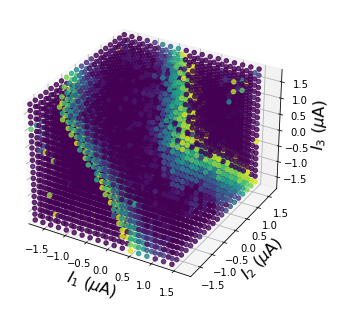

In [3]:
fig = plt.figure()
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

scat = ax.scatter(X_expt_orig[:, 0], 
            X_expt_orig[:, 1],
            X_expt_orig[:, 2], marker='o', c=probs_orig, s=20, alpha=0.8, vmin=0, vmax=1)

In [4]:
def get_performance_AL(X, probs_expt, params):
    probs_pred = fitting.sigmoidND_nonlinear(sm.add_constant(X, has_constant='add'),
                                             params)

    RMSE = np.sqrt(np.sum((probs_pred - probs_expt)**2) / len(X))

    return RMSE

In [5]:
def get_R2_AL(X, probs_expt, trials, params):
    X_bin, y_bin = fitting.convertToBinaryClassifier(probs_expt, trials, X)

    ybar = np.mean(y_bin)
    beta_null = np.log(ybar / (1 - ybar))
    null_weights = np.concatenate((np.array([beta_null]), np.zeros(X.shape[-1])))
    nll_null = fitting.negLL_hotspot(null_weights, X_bin, y_bin, False, 'none', 0)

    nll_opt = fitting.negLL_hotspot(params, X_bin, y_bin, False, 'none', 0)

    return 1 - nll_opt / nll_null

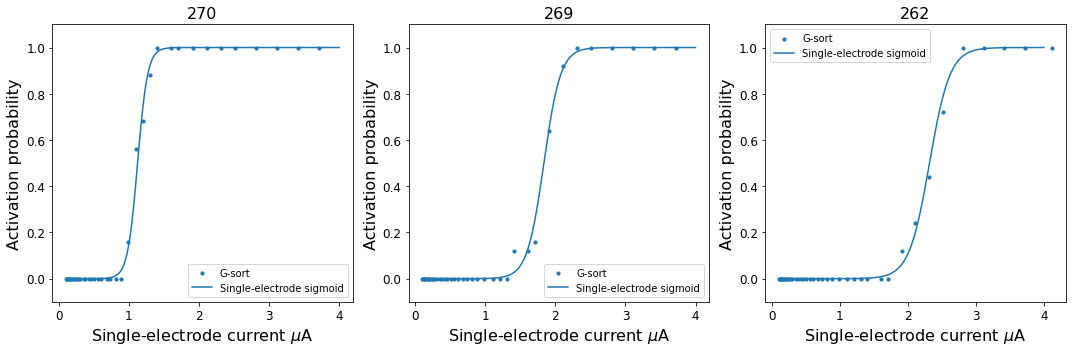

In [6]:
triplet_elecs = mutils.get_stim_elecs_newlv(electrical_path, p)

SE_params = np.zeros((len(triplet_elecs), 2))
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for j in range(len(triplet_elecs)):
    currs_1d, Ivals, sigmoid, probs_1elec, params = mutils.get1elecCurve(dataset, gsort_path_1elec, estim_1elec, wnoise, 
                                                        triplet_elecs[j], cell, spont_limit=0.2, return_params=True)

    SE_params[j] = params
    axs[j].scatter(Ivals[:len(probs_1elec)], probs_1elec, s=10, label='G-sort')
    axs[j].plot(currs_1d, sigmoid, label='Single-electrode sigmoid')
    axs[j].set_xlabel(r'Single-electrode current $\mu$A', fontsize=16)
    axs[j].set_ylabel(r'Activation probability', fontsize=16)
    axs[j].tick_params(labelsize=12)
    axs[j].set_ylim(-0.1, 1.1)
    axs[j].legend(fontsize=10)
    axs[j].set_title(str(triplet_elecs[j]), fontsize=16)

fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.show()

thresholds = -SE_params[:, 0] / SE_params[:, 1]
weights_1elec = np.concatenate((np.array([SE_params[np.argmin(thresholds), 0]]), 
                            SE_params[:, 1] / SE_params[:, 0] * SE_params[np.argmin(thresholds), 0]))
weights_1elec_neg = np.concatenate((np.array([SE_params[np.argmin(thresholds), 0]]), 
                            -SE_params[:, 1] / SE_params[:, 0] * SE_params[np.argmin(thresholds), 0]))
params_1elec = np.vstack((weights_1elec, weights_1elec_neg))

surf_1elec = fitting.sigmoidND_nonlinear(sm.add_constant(X_expt_orig, has_constant='add'), params_1elec)

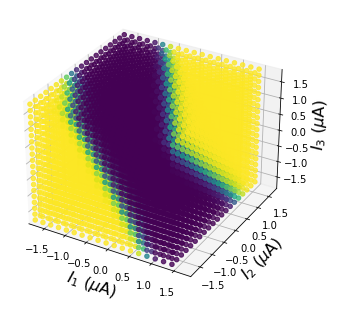

In [7]:
fig = plt.figure()
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

scat = ax.scatter(X_expt_orig[:, 0], 
            X_expt_orig[:, 1],
            X_expt_orig[:, 2], marker='o', c=surf_1elec, 
            s=20, alpha=0.8, vmin=0, vmax=1)

In [8]:
method = 'L-BFGS-B'
jac = fitting.negLL_hotspot_jac
l2_reg = 0.1

X_expt, probs, T = mutils.triplet_cleaning(X_expt_orig, probs_orig, T_orig, electrical_path, p)
params_full = fitting.fit_triplet_surface(X_expt, probs, T, method=method, jac=jac, starting_m=2, max_sites=2, reg_method='l2', 
                                          reg=l2_reg, initialization=params_1elec)
performance_full = get_performance_AL(X_expt, probs, params_full)
R2_full = get_R2_AL(X_expt, probs, T, params_full)

/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:360: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if initialization == 'multiprocessing':


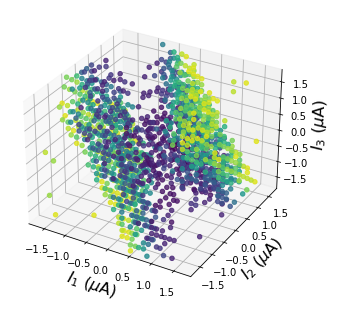

In [9]:
fig = plt.figure()
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

scat = ax.scatter(X_expt[:, 0], 
            X_expt[:, 1],
            X_expt[:, 2], marker='o', c=probs, s=20, alpha=0.8, vmin=0, vmax=1)

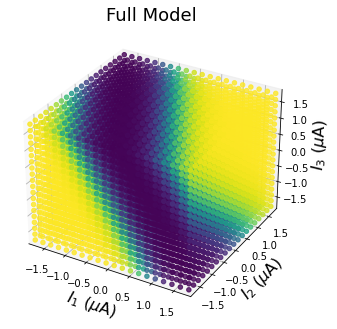

In [10]:
fig = plt.figure()
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
plt.title('Full Model', fontsize=18)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

scat = ax.scatter(X_all[:, 0], 
            X_all[:, 1],
            X_all[:, 2], marker='o', c=fitting.sigmoidND_nonlinear(sm.add_constant(X_all, has_constant='add'), params_full), 
            s=20, alpha=0.8, vmin=0, vmax=1)


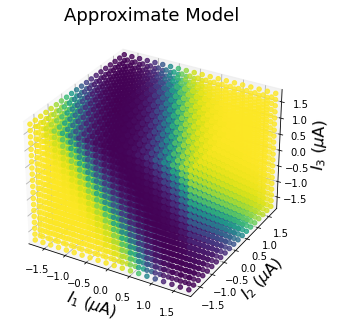

In [11]:
fig = plt.figure()
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
plt.title('Approximate Model', fontsize=18)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

scat = ax.scatter(X_all[:, 0], 
            X_all[:, 1],
            X_all[:, 2], marker='o', c=fitting.sigmoidND_nonlinear_max(sm.add_constant(X_all, has_constant='add'), params_full), 
            s=20, alpha=0.8, vmin=0, vmax=1)

In [12]:
X_l = sm.add_constant(X_expt, has_constant='add')
X_u = sm.add_constant(X_all, has_constant='add')

In [13]:
variances = fitting.var_max(X_l, X_u, params_full, l2_reg=l2_reg)

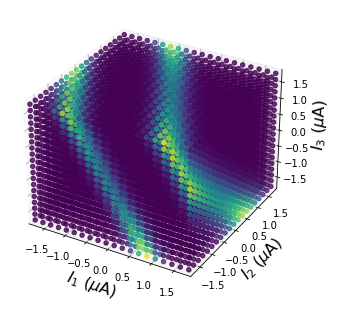

In [14]:
fig = plt.figure()
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

scat = ax.scatter(X_all[:, 0], 
            X_all[:, 1],
            X_all[:, 2], marker='o', c=variances, 
            s=20, alpha=0.8)

In [15]:
get_performance_AL(X_expt, probs, params_1elec), get_R2_AL(X_expt, probs, T, params_1elec)

(0.21810360117191488, -0.1719698826904359)

In [16]:
performance_full, R2_full

(0.08261603754026442, 0.2630092959314555)

In [17]:
params_1elec

array([[-15.69190172,  13.96952715,   8.54930926,   6.77277285],
       [-15.69190172, -13.96952715,  -8.54930926,  -6.77277285]])

In [18]:
params_full

array([[-5.52205573,  4.71543945,  2.44937824,  2.33432666],
       [-5.62175325, -5.58243502, -2.93199607, -2.78553141]])

In [19]:
bound_1elec = 0.49
init_size = 50

inds_1elec = np.where(np.absolute(surf_1elec - 0.5) <= bound_1elec)[0]
init_inds = np.random.choice(inds_1elec, replace=False, size=init_size)

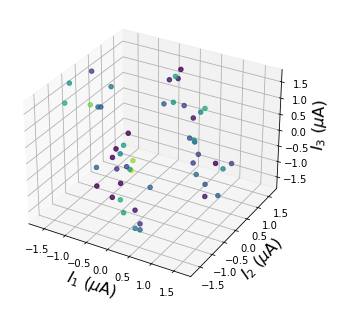

In [20]:
fig = plt.figure()
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

scat = ax.scatter(X_expt_orig[init_inds, 0], 
            X_expt_orig[init_inds, 1],
            X_expt_orig[init_inds, 2], marker='o', c=probs_orig[init_inds], s=20, alpha=0.8, vmin=0, vmax=1)

## Option 1: Fit twice per iteration

In [ ]:
noise_thr = 0.15
zero_prob = 0.01
proximity_thr = 0.45
m = 2
batch_size = 20
exploit = 0.5
exploit_batch = int(exploit * batch_size)
explore_batch = batch_size - exploit_batch
max_samples = 300
flip_thr = 0.5
bound_1elec = 0.45
init_size = 50
inds_1elec = np.where(np.absolute(surf_1elec - 0.5) <= bound_1elec)[0]

method = 'L-BFGS-B'
jac = fitting.negLL_hotspot_jac

num_restarts = 100

performance_stack = []
performance_stack_random = []
for restart in range(num_restarts):
    # np.random.seed(restart)
    print(restart+1)
    init_inds = np.random.choice(inds_1elec, replace=False, size=init_size)

    curr_inds = init_inds
    remaining_inds = np.setdiff1d(np.arange(len(X_expt_orig), dtype=int), init_inds)

    curr_inds_random = curr_inds
    remaining_inds_random = remaining_inds

    last_fit = params_1elec
    last_fit_random = params_1elec

    performances = []
    performances_random = []

    num_samples = []

    while True:
        num_samples.append(len(curr_inds))
        X_sub, probs_sub, T_sub = X_expt_orig[curr_inds], probs_orig[curr_inds], T_orig[curr_inds]
        X_sub_random, probs_sub_random, T_sub_random = X_expt_orig[curr_inds_random], probs_orig[curr_inds_random], T_orig[curr_inds_random]

        # fig = plt.figure(0)
        # fig.clear()
        # ax = Axes3D(fig, auto_add_to_figure=False)
        # fig.add_axes(ax)
        # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        # plt.xlim(-1.8, 1.8)
        # plt.ylim(-1.8, 1.8)

        # ax.set_zlim(-1.8, 1.8)
        # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X_sub[:, 0], 
        #             X_sub[:, 1],
        #             X_sub[:, 2], marker='o', c=probs_sub, s=20, alpha=0.8, vmin=0, vmax=1)

        good_inds = np.where(probs_sub > noise_thr)[0]
        low_inds = np.where(probs_sub <= noise_thr)[0]
        X_sub_clean, probs_sub_clean, T_sub_clean = X_sub[good_inds], probs_sub[good_inds], T_sub[good_inds]

        X_bin, y_bin = fitting.convertToBinaryClassifier(probs_sub_clean, T_sub_clean, X_sub_clean)

        ybar = np.mean(y_bin)
        beta_null = np.log(ybar / (1 - ybar))
        null_weights = np.concatenate((np.array([beta_null]), np.zeros(X_sub_clean.shape[-1])))
        nll_null = fitting.negLL_hotspot(null_weights, X_bin, y_bin, False, 'none', 0)

        opt = fitting.get_w(m, X_bin, y_bin, nll_null, initialization=last_fit, zero_prob=zero_prob, method=method, jac=jac)
        curr_params = opt[0]
        # print(opt)
        # curr_pred = fitting.sigmoidND_nonlinear(sm.add_constant(X_all, has_constant='add'),
        #                                             curr_params)

        low_pred = fitting.sigmoidND_nonlinear(sm.add_constant(X_sub[low_inds], has_constant='add'), curr_params)
        probs_sub[low_inds[np.where(low_pred > flip_thr)[0]]] = 1

        X_bin, y_bin = fitting.convertToBinaryClassifier(probs_sub, T_sub, X_sub)

        ybar = np.mean(y_bin)
        beta_null = np.log(ybar / (1 - ybar))
        null_weights = np.concatenate((np.array([beta_null]), np.zeros(X_sub.shape[-1])))
        nll_null = fitting.negLL_hotspot(null_weights, X_bin, y_bin, False, 'none', 0)

        opt = fitting.get_w(m, X_bin, y_bin, nll_null, initialization=curr_params, zero_prob=zero_prob, method=method, jac=jac)
        curr_params = opt[0]
        curr_R2 = get_R2_AL(X_expt, probs, T, curr_params)
        last_fit = curr_params
        curr_performance = get_performance_AL(X_expt, probs, curr_params)
        # print(opt)

        remaining_pred = fitting.sigmoidND_nonlinear(sm.add_constant(X_expt_orig[remaining_inds], has_constant='add'),
                                                        curr_params)

        good_inds_random = np.where(probs_sub_random > noise_thr)[0]
        low_inds_random = np.where(probs_sub_random <= noise_thr)[0]
        X_sub_clean_random, probs_sub_clean_random, T_sub_clean_random = X_sub_random[good_inds_random], probs_sub_random[good_inds_random], T_sub_random[good_inds_random]

        X_bin, y_bin = fitting.convertToBinaryClassifier(probs_sub_clean_random, T_sub_clean_random, X_sub_clean_random)

        ybar = np.mean(y_bin)
        beta_null = np.log(ybar / (1 - ybar))
        null_weights = np.concatenate((np.array([beta_null]), np.zeros(X_sub_clean_random.shape[-1])))
        nll_null = fitting.negLL_hotspot(null_weights, X_bin, y_bin, False, 'none', 0)

        opt = fitting.get_w(m, X_bin, y_bin, nll_null, initialization=last_fit_random, zero_prob=zero_prob, method=method, jac=jac)
        curr_params_random = opt[0]
        # print(opt)
        # curr_pred = fitting.sigmoidND_nonlinear(sm.add_constant(X_all, has_constant='add'),
        #                                             curr_params)

        low_pred_random = fitting.sigmoidND_nonlinear(sm.add_constant(X_sub_random[low_inds_random], has_constant='add'), curr_params_random)
        probs_sub_random[low_inds_random[np.where(low_pred_random > flip_thr)[0]]] = 1

        X_bin, y_bin = fitting.convertToBinaryClassifier(probs_sub_random, T_sub_random, X_sub_random)

        ybar = np.mean(y_bin)
        beta_null = np.log(ybar / (1 - ybar))
        null_weights = np.concatenate((np.array([beta_null]), np.zeros(X_sub_random.shape[-1])))
        nll_null = fitting.negLL_hotspot(null_weights, X_bin, y_bin, False, 'none', 0)

        opt = fitting.get_w(m, X_bin, y_bin, nll_null, initialization=curr_params_random, zero_prob=zero_prob, method=method, jac=jac)
        curr_params_random = opt[0]
        curr_R2_random = get_R2_AL(X_expt, probs, T, curr_params_random)
        last_fit_random = curr_params_random
        curr_performance_random = get_performance_AL(X_expt, probs, curr_params_random)

        # fig = plt.figure(1)
        # fig.clear()
        # ax = Axes3D(fig, auto_add_to_figure=False)
        # fig.add_axes(ax)
        # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        # plt.xlim(-1.8, 1.8)
        # plt.ylim(-1.8, 1.8)

        # ax.set_zlim(-1.8, 1.8)
        # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X_sub[:, 0], 
        #             X_sub[:, 1],
        #             X_sub[:, 2], marker='o', c=probs_sub, s=20, alpha=0.8, vmin=0, vmax=1)

        print(curr_R2, curr_R2_random)
        performances.append(curr_R2)
        performances_random.append(curr_R2_random)

        if len(curr_inds) >= max_samples:
            break

        # fig = plt.figure(2)
        # fig.clear()
        # ax = Axes3D(fig, auto_add_to_figure=False)
        # fig.add_axes(ax)
        # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        # plt.xlim(-1.8, 1.8)
        # plt.ylim(-1.8, 1.8)
        # ax.set_zlim(-1.8, 1.8)
        # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X_all[:, 0], 
        #             X_all[:, 1],
        #             X_all[:, 2], marker='o', c=curr_pred, s=20, alpha=0.8, vmin=0, vmax=1)

        possible_inds = remaining_inds[np.where(np.absolute(remaining_pred - 0.5) <= proximity_thr)[0]]
        d_nmx = cdist(X_expt_orig[possible_inds], X_sub)
        d_nx = np.amin(d_nmx, axis=1)

        p_exploit = d_nx**2 / np.sum(d_nx**2)
        exploit_inds = np.random.choice(possible_inds,
                                        p=p_exploit,
                                        replace=False,
                                        size=exploit_batch)

        # fig = plt.figure(5)
        # fig.clear()
        # ax = Axes3D(fig, auto_add_to_figure=False)
        # fig.add_axes(ax)
        # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        # plt.xlim(-1.8, 1.8)
        # plt.ylim(-1.8, 1.8)
        # ax.set_zlim(-1.8, 1.8)
        # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X_expt_orig[exploit_inds, 0], 
        #             X_expt_orig[exploit_inds, 1],
        #             X_expt_orig[exploit_inds, 2], marker='o', c=probs_orig[exploit_inds], s=20, alpha=0.8, vmin=0, vmax=1)

        p_explore = np.amin(cdist(X_expt_orig[np.setdiff1d(remaining_inds, exploit_inds)], X_sub), axis=1)**2
        p_explore = p_explore / np.sum(p_explore)

        explore_inds = np.random.choice(np.setdiff1d(remaining_inds, exploit_inds),
                                        p=p_explore,
                                        replace=False,
                                        size=explore_batch)

        # fig = plt.figure(6)
        # fig.clear()
        # ax = Axes3D(fig, auto_add_to_figure=False)
        # fig.add_axes(ax)
        # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        # plt.xlim(-1.8, 1.8)
        # plt.ylim(-1.8, 1.8)
        # ax.set_zlim(-1.8, 1.8)
        # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X_expt_orig[explore_inds, 0], 
        #             X_expt_orig[explore_inds, 1],
        #             X_expt_orig[explore_inds, 2], marker='o', c=probs_orig[explore_inds], s=20, alpha=0.8, vmin=0, vmax=1)

        next_inds = np.concatenate((exploit_inds, explore_inds))
        curr_inds = np.concatenate((curr_inds, next_inds))
        remaining_inds = np.setdiff1d(remaining_inds, curr_inds)

        next_inds_random = np.random.choice(remaining_inds_random, replace=False, size=batch_size)
        curr_inds_random = np.concatenate((curr_inds_random, next_inds_random))
        remaining_inds_random = np.setdiff1d(remaining_inds_random, curr_inds_random)

        # plt.show()
        # input()

    num_samples = np.array(num_samples)

    performance_stack.append(np.array(performances))
    performance_stack_random.append(np.array(performances_random))

performance_stack = np.array(performance_stack)
performance_stack_random = np.array(performance_stack_random)


In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(num_samples, np.mean(performance_stack, axis=0), label='Active Learning, 50% Exploit', linewidth=4)
plt.plot(num_samples, np.mean(performance_stack_random, axis=0), label='Random Baseline', linewidth=4)
plt.axhline(R2_full, c='k', linestyle='--', label='Full Dataset Limit', linewidth=4)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Number of Amplitudes Sampled', fontsize=24)
plt.ylabel(r'McFadden Pseudo $R^2$', fontsize=24)
plt.legend(fontsize=22)
plt.ylim(0.36, 0.4)

## Option 2: Use previous fit for D&D

In [ ]:
noise_thr = 0.15
zero_prob = 0.01
# proximity_thr = 0.49
m = 2
batch_size = 10

# exploit2 = 0
# exploit_batch2 = int(exploit2 * batch_size)
# explore_batch2 = batch_size - exploit_batch2

max_samples = 300
flip_thr = 0.5
bound_1elec = 0.49
init_size = 100
inds_1elec = np.where(np.absolute(surf_1elec - 0.5) <= bound_1elec)[0]

method = 'L-BFGS-B'
jac = fitting.negLL_hotspot_jac

num_restarts = 100

performance_stack = []
# performance_stack2 = []
performance_stack_random = []
# high_value = []
for restart in range(num_restarts):
    print(restart+1)
    init_inds = np.random.choice(inds_1elec, replace=False, size=init_size)
    # init_inds = np.random.choice(np.arange(len(X_expt_orig), dtype=int), replace=False, size=init_size)

    curr_inds = init_inds
    remaining_inds = np.setdiff1d(np.arange(len(X_expt_orig), dtype=int), init_inds)

    # fig = plt.figure(0)
    # fig.clear()
    # ax = Axes3D(fig, auto_add_to_figure=False)
    # fig.add_axes(ax)
    # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
    # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
    # plt.xlim(-1.8, 1.8)
    # plt.ylim(-1.8, 1.8)

    # ax.set_zlim(-1.8, 1.8)
    # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

    # scat = ax.scatter(X_expt_orig[init_inds, 0], 
    #             X_expt_orig[init_inds, 1],
    #             X_expt_orig[init_inds, 2], marker='o', c=probs_orig[init_inds], s=20, alpha=0.8, vmin=0, vmax=1)

    # curr_inds2 = curr_inds
    # remaining_inds2 = remaining_inds

    curr_inds_random = curr_inds
    remaining_inds_random = remaining_inds

    last_fit = params_1elec
    # last_fit2 = params_1elec
    last_fit_random = params_1elec

    performances = []
    # performances2 = []
    performances_random = []

    num_samples = []

    # counter = 1
    while True:
        # exploit = counter / 20
        # exploit_batch = int(exploit * batch_size)
        # explore_batch = batch_size - exploit_batch

        num_samples.append(len(curr_inds))
        X_sub, probs_sub, T_sub = X_expt_orig[curr_inds], probs_orig[curr_inds], T_orig[curr_inds]
        # X_sub2, probs_sub2, T_sub2 = X_expt_orig[curr_inds2], probs_orig[curr_inds2], T_orig[curr_inds2]
        X_sub_random, probs_sub_random, T_sub_random = X_expt_orig[curr_inds_random], probs_orig[curr_inds_random], T_orig[curr_inds_random]

        # fig = plt.figure(0)
        # fig.clear()
        # ax = Axes3D(fig, auto_add_to_figure=False)
        # fig.add_axes(ax)
        # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        # plt.xlim(-1.8, 1.8)
        # plt.ylim(-1.8, 1.8)

        # ax.set_zlim(-1.8, 1.8)
        # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X_sub[:, 0], 
        #             X_sub[:, 1],
        #             X_sub[:, 2], marker='o', c=probs_sub, s=20, alpha=0.8, vmin=0, vmax=1)

        low_inds = np.where(probs_sub <= noise_thr)[0]
        low_pred = fitting.sigmoidND_nonlinear(sm.add_constant(X_sub[low_inds], has_constant='add'), last_fit)
        probs_sub[low_inds[np.where(low_pred > flip_thr)[0]]] = 1

        # low_inds2 = np.where(probs_sub2 <= noise_thr)[0]
        # low_pred2 = fitting.sigmoidND_nonlinear(sm.add_constant(X_sub2[low_inds2], has_constant='add'), last_fit2)
        # probs_sub2[low_inds2[np.where(low_pred2 > flip_thr)[0]]] = 1

        low_inds_random = np.where(probs_sub_random <= noise_thr)[0]
        low_pred_random = fitting.sigmoidND_nonlinear(sm.add_constant(X_sub_random[low_inds_random], has_constant='add'), last_fit_random)
        probs_sub_random[low_inds_random[np.where(low_pred_random > flip_thr)[0]]] = 1

        # fig = plt.figure(1)
        # fig.clear()
        # ax = Axes3D(fig, auto_add_to_figure=False)
        # fig.add_axes(ax)
        # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        # plt.xlim(-1.8, 1.8)
        # plt.ylim(-1.8, 1.8)

        # ax.set_zlim(-1.8, 1.8)
        # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X_sub[:, 0], 
        #             X_sub[:, 1],
        #             X_sub[:, 2], marker='o', c=probs_sub, s=20, alpha=0.8, vmin=0, vmax=1)

        X_bin, y_bin = fitting.convertToBinaryClassifier(probs_sub, T_sub, X_sub)
        ybar = np.mean(y_bin)
        beta_null = np.log(ybar / (1 - ybar))
        null_weights = np.concatenate((np.array([beta_null]), np.zeros(X_sub.shape[-1])))
        nll_null = fitting.negLL_hotspot(null_weights, X_bin, y_bin, False, 'none', 0)

        opt = fitting.get_w(m, X_bin, y_bin, nll_null, initialization=params_1elec, zero_prob=zero_prob, method=method, jac=jac, reg_method='l2', reg=l2_reg)
        curr_params = opt[0]
        curr_R2 = get_R2_AL(X_expt, probs, T, curr_params)

        # print(opt)
        curr_performance = get_performance_AL(X_expt, probs, curr_params)

        # X_bin2, y_bin2 = fitting.convertToBinaryClassifier(probs_sub2, T_sub2, X_sub2)
        # ybar2 = np.mean(y_bin2)
        # beta_null2 = np.log(ybar2 / (1 - ybar2))
        # null_weights2 = np.concatenate((np.array([beta_null2]), np.zeros(X_sub2.shape[-1])))
        # nll_null2 = fitting.negLL_hotspot(null_weights2, X_bin2, y_bin2, False, 'none', 0)

        # opt2 = fitting.get_w(m, X_bin2, y_bin2, nll_null2, initialization=last_fit2, zero_prob=zero_prob, method=method, jac=jac)
        # curr_params2 = opt2[0]
        # curr_R22 = get_R2_AL(X_expt, probs, T, curr_params2)
        # # print(opt)
        # curr_performance2 = get_performance_AL(X_expt, probs, curr_params2)

        X_bin_random, y_bin_random = fitting.convertToBinaryClassifier(probs_sub_random, T_sub_random, X_sub_random)
        ybar_random = np.mean(y_bin_random)
        beta_null_random = np.log(ybar_random / (1 - ybar_random))
        null_weights_random = np.concatenate((np.array([beta_null_random]), np.zeros(X_sub_random.shape[-1])))
        nll_null_random = fitting.negLL_hotspot(null_weights_random, X_bin_random, y_bin_random, False, 'none', 0)

        opt_random = fitting.get_w(m, X_bin_random, y_bin_random, nll_null_random, initialization=params_1elec, zero_prob=zero_prob, method=method, jac=jac, 
                                   reg_method='l2', reg=l2_reg)
        curr_params_random = opt_random[0]
        curr_R2_random = get_R2_AL(X_expt, probs, T, curr_params_random)
        # print(opt)
        curr_performance_random = get_performance_AL(X_expt, probs, curr_params_random)

        # print(curr_params, curr_params_random)
        # print(curr_R2, curr_R22, curr_R2_random)

        print(curr_R2, curr_R2_random, curr_performance, curr_performance_random)
        performances.append(curr_performance)
        # performances2.append(curr_R22)
        performances_random.append(curr_performance_random)
        # curr_pred = fitting.sigmoidND_nonlinear(sm.add_constant(X_all, has_constant='add'),
        #                                             curr_params)
        # curr_pred_random = fitting.sigmoidND_nonlinear(sm.add_constant(X_all, has_constant='add'),
        #                                             curr_params_random)

        # remaining_pred = fitting.sigmoidND_nonlinear(sm.add_constant(X_expt_orig[remaining_inds], has_constant='add'),
        #                                                 curr_params)
        
        # remaining_pred2 = fitting.sigmoidND_nonlinear(sm.add_constant(X_expt_orig[remaining_inds2], has_constant='add'),
        #                                                 curr_params2)
        last_fit = curr_params
        # last_fit2 = curr_params2
        last_fit_random = curr_params_random

        if len(curr_inds) >= max_samples:
            # fig = plt.figure(2)
            # fig.clear()
            # ax = Axes3D(fig, auto_add_to_figure=False)
            # fig.add_axes(ax)
            # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            # plt.xlim(-1.8, 1.8)
            # plt.ylim(-1.8, 1.8)
            # ax.set_zlim(-1.8, 1.8)
            # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            # scat = ax.scatter(X_all[:, 0], 
            #             X_all[:, 1],
            #             X_all[:, 2], marker='o', c=curr_pred, s=20, alpha=0.8, vmin=0, vmax=1)

            # fig = plt.figure(3)
            # fig.clear()
            # ax = Axes3D(fig, auto_add_to_figure=False)
            # fig.add_axes(ax)
            # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            # plt.xlim(-1.8, 1.8)
            # plt.ylim(-1.8, 1.8)
            # ax.set_zlim(-1.8, 1.8)
            # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            # scat = ax.scatter(X_all[:, 0], 
            #             X_all[:, 1],
            #             X_all[:, 2], marker='o', c=curr_pred_random, s=20, alpha=0.8, vmin=0, vmax=1)

            # print(curr_params)
            # print(curr_params_random)
            break

        # fig = plt.figure(2)
        # fig.clear()
        # ax = Axes3D(fig, auto_add_to_figure=False)
        # fig.add_axes(ax)
        # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        # plt.xlim(-1.8, 1.8)
        # plt.ylim(-1.8, 1.8)
        # ax.set_zlim(-1.8, 1.8)
        # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X_all[:, 0], 
        #             X_all[:, 1],
        #             X_all[:, 2], marker='o', c=curr_pred, s=20, alpha=0.8, vmin=0, vmax=1)

        # possible_inds = remaining_inds[np.where(np.absolute(remaining_pred - 0.5) <= proximity_thr)[0]]
        # d_nmx = cdist(X_expt_orig[possible_inds], X_sub)
        # d_nx = np.amin(d_nmx, axis=1)

        # p_exploit = d_nx**2 / np.sum(d_nx**2)
        # if exploit_batch >= len(possible_inds):
        #     exploit_inds = possible_inds
            
        # else:
        #     exploit_inds = np.random.choice(possible_inds,
        #                                     p=p_exploit,
        #                                     replace=False,
        #                                     size=exploit_batch)

        # possible_inds2 = remaining_inds2[np.where(np.absolute(remaining_pred2 - 0.5) <= proximity_thr)[0]]
        # d_nmx2 = cdist(X_expt_orig[possible_inds2], X_sub2)
        # d_nx2 = np.amin(d_nmx2, axis=1)

        # p_exploit2 = d_nx2**2 / np.sum(d_nx2**2)
        # if exploit_batch2 >= len(possible_inds2):
        #     exploit_inds2 = possible_inds2
            
        # else:
        #     exploit_inds2 = np.random.choice(possible_inds2,
        #                                     p=p_exploit2,
        #                                     replace=False,
        #                                     size=exploit_batch2)

        # fig = plt.figure(5)
        # fig.clear()
        # ax = Axes3D(fig, auto_add_to_figure=False)
        # fig.add_axes(ax)
        # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        # plt.xlim(-1.8, 1.8)
        # plt.ylim(-1.8, 1.8)
        # ax.set_zlim(-1.8, 1.8)
        # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X_expt_orig[exploit_inds, 0], 
        #             X_expt_orig[exploit_inds, 1],
        #             X_expt_orig[exploit_inds, 2], marker='o', c=probs_orig[exploit_inds], s=20, alpha=0.8, vmin=0, vmax=1)

        # p_explore = np.amin(cdist(X_expt_orig[np.setdiff1d(remaining_inds, exploit_inds)], X_sub), axis=1)**2
        # p_explore = p_explore / np.sum(p_explore)

        # explore_inds = np.random.choice(np.setdiff1d(remaining_inds, exploit_inds),
        #                                 p=p_explore,
        #                                 replace=False,
        #                                 size=explore_batch)

        # explore_inds = np.random.choice(np.setdiff1d(remaining_inds, exploit_inds), replace=False, size=explore_batch)

        # p_explore2 = np.amin(cdist(X_expt_orig[np.setdiff1d(remaining_inds2, exploit_inds2)], X_sub2), axis=1)**2
        # p_explore2 = p_explore2 / np.sum(p_explore2)

        # explore_inds2 = np.random.choice(np.setdiff1d(remaining_inds2, exploit_inds2),
        #                                 p=p_explore2,
        #                                 replace=False,
        #                                 size=explore_batch2)

        # fig = plt.figure(6)
        # fig.clear()
        # ax = Axes3D(fig, auto_add_to_figure=False)
        # fig.add_axes(ax)
        # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        # plt.xlim(-1.8, 1.8)
        # plt.ylim(-1.8, 1.8)
        # ax.set_zlim(-1.8, 1.8)
        # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X_expt_orig[explore_inds, 0], 
        #             X_expt_orig[explore_inds, 1],
        #             X_expt_orig[explore_inds, 2], marker='o', c=probs_orig[explore_inds], s=20, alpha=0.8, vmin=0, vmax=1)

        variances = fitting.var_max(sm.add_constant(X_sub, has_constant='add'),
                                    sm.add_constant(X_expt_orig[remaining_inds], has_constant='add'),
                                    curr_params,
                                    l2_reg=l2_reg)

        next_inds = remaining_inds[np.flip(np.argsort(variances))[0:batch_size]]
        # exploit_inds = remaining_inds[np.flip(np.argsort(variances))[0:exploit_batch]]
        # explore_inds = np.random.choice(np.setdiff1d(remaining_inds, exploit_inds), replace=False, size=explore_batch)
        # next_inds = np.concatenate((exploit_inds, explore_inds))
        curr_inds = np.concatenate((curr_inds, next_inds))
        remaining_inds = np.setdiff1d(remaining_inds, curr_inds)

        # next_inds2 = np.concatenate((exploit_inds2, explore_inds2))
        # curr_inds2 = np.concatenate((curr_inds2, next_inds2))
        # remaining_inds2 = np.setdiff1d(remaining_inds2, curr_inds2)

        # MMC = fitting.negLL_MMC(curr_params2, X_expt_orig[remaining_inds2])
        # next_inds2 = remaining_inds2[np.argsort(MMC)[-batch_size:]]
        # curr_inds2 = np.concatenate((curr_inds2, next_inds2))
        # remaining_inds2 = np.setdiff1d(remaining_inds2, curr_inds2)

        next_inds_random = np.random.choice(remaining_inds_random, replace=False, size=batch_size)
        curr_inds_random = np.concatenate((curr_inds_random, next_inds_random))
        remaining_inds_random = np.setdiff1d(remaining_inds_random, curr_inds_random)

        # fig = plt.figure(7)
        # fig.clear()
        # ax = Axes3D(fig, auto_add_to_figure=False)
        # fig.add_axes(ax)
        # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        # plt.xlim(-1.8, 1.8)
        # plt.ylim(-1.8, 1.8)
        # ax.set_zlim(-1.8, 1.8)
        # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X_expt_orig[next_inds, 0], 
        #             X_expt_orig[next_inds, 1],
        #             X_expt_orig[next_inds, 2], marker='o', c=probs_orig[next_inds], s=20, alpha=0.8, vmin=0, vmax=1)
                    
        # fig = plt.figure(8)
        # fig.clear()
        # ax = Axes3D(fig, auto_add_to_figure=False)
        # fig.add_axes(ax)
        # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        # plt.xlim(-1.8, 1.8)
        # plt.ylim(-1.8, 1.8)
        # ax.set_zlim(-1.8, 1.8)
        # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X_expt_orig[next_inds2, 0], 
        #             X_expt_orig[next_inds2, 1],
        #             X_expt_orig[next_inds2, 2], marker='o', c=probs_orig[next_inds2], s=20, alpha=0.8, vmin=0, vmax=1)

        # fig = plt.figure(9)
        # fig.clear()
        # ax = Axes3D(fig, auto_add_to_figure=False)
        # fig.add_axes(ax)
        # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        # plt.xlim(-1.8, 1.8)
        # plt.ylim(-1.8, 1.8)
        # ax.set_zlim(-1.8, 1.8)
        # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X_expt_orig[next_inds_random, 0], 
        #             X_expt_orig[next_inds_random, 1],
        #             X_expt_orig[next_inds_random, 2], marker='o', c=probs_orig[next_inds_random], s=20, alpha=0.8, vmin=0, vmax=1)

        # print(X_expt_orig[next_inds], probs_orig[next_inds])
        # # print(X_expt_orig[next_inds2], probs_orig[next_inds2])
        # print(X_expt_orig[next_inds_random], probs_orig[next_inds_random])
        # plt.show()
        # input()

        # counter += 1

    num_samples = np.array(num_samples)

    performance_stack.append(np.array(performances))
    # performance_stack2.append(np.array(performances2))
    performance_stack_random.append(np.array(performances_random))

    # plt.show()
    # input()

performance_stack = np.array(performance_stack)
# performance_stack2 = np.array(performance_stack2)
performance_stack_random = np.array(performance_stack_random)


In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(num_samples, np.mean(performance_stack, axis=0), label='Active Learning', linewidth=4)
# plt.plot(num_samples, np.mean(performance_stack2, axis=0), label='Active Learning, 0% Exploit', linewidth=4)
plt.plot(num_samples, np.mean(performance_stack_random, axis=0), label='Random Baseline', linewidth=4)
plt.axhline(performance_full, c='k', linestyle='--', label='Full Dataset Limit', linewidth=4)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Number of Amplitudes Sampled', fontsize=24)
# plt.ylabel(r'McFadden Pseudo $R^2$', fontsize=24)
plt.ylabel(r'RMSE', fontsize=24)
plt.legend(fontsize=20)
# plt.ylim(0.36, 0.4)

## Option 3: Throw out everything outside the surface

In [ ]:
zero_prob = 0.01
proximity_thr = 0.2
m = 2
batch_size = 20

exploit = 0
exploit_batch = int(exploit * batch_size)
explore_batch = batch_size - exploit_batch

# exploit2 = 0
# exploit_batch2 = int(exploit2 * batch_size)
# explore_batch2 = batch_size - exploit_batch2

max_samples = 300
discard_thr = 0.99
bound_1elec = 0.49
init_size = 50
inds_1elec = np.where(np.absolute(surf_1elec - 0.5) <= bound_1elec)[0]

method = 'L-BFGS-B'
jac = fitting.negLL_hotspot_jac

num_restarts = 100

performance_stack = []
# performance_stack2 = []
performance_stack_random = []
high_value = []
for restart in range(num_restarts):
    print(restart+1)
    init_inds = np.random.choice(inds_1elec, replace=False, size=init_size)

    curr_inds = init_inds
    remaining_inds = np.setdiff1d(np.arange(len(X_expt_orig), dtype=int), init_inds)

    # curr_inds2 = curr_inds
    # remaining_inds2 = remaining_inds

    curr_inds_random = curr_inds
    remaining_inds_random = remaining_inds

    last_fit = params_1elec
    # last_fit2 = params_1elec
    last_fit_random = params_1elec

    performances = []
    # performances2 = []
    performances_random = []

    num_samples = []

    while True:
        num_samples.append(len(curr_inds))
        X_sub, probs_sub, T_sub = X_expt_orig[curr_inds], probs_orig[curr_inds], T_orig[curr_inds]
        # X_sub2, probs_sub2, T_sub2 = X_expt_orig[curr_inds2], probs_orig[curr_inds2], T_orig[curr_inds2]
        X_sub_random, probs_sub_random, T_sub_random = X_expt_orig[curr_inds_random], probs_orig[curr_inds_random], T_orig[curr_inds_random]

        # fig = plt.figure(0)
        # fig.clear()
        # ax = Axes3D(fig, auto_add_to_figure=False)
        # fig.add_axes(ax)
        # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        # plt.xlim(-1.8, 1.8)
        # plt.ylim(-1.8, 1.8)

        # ax.set_zlim(-1.8, 1.8)
        # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X_sub[:, 0], 
        #             X_sub[:, 1],
        #             X_sub[:, 2], marker='o', c=probs_sub, s=20, alpha=0.8, vmin=0, vmax=1)

        pred_sub = fitting.sigmoidND_nonlinear(sm.add_constant(X_sub, has_constant='add'), last_fit)
        good_inds = np.where(pred_sub <= discard_thr)[0]
        X_sub, probs_sub, T_sub = X_sub[good_inds], probs_sub[good_inds], T_sub[good_inds]

        # low_inds2 = np.where(probs_sub2 <= noise_thr)[0]
        # low_pred2 = fitting.sigmoidND_nonlinear(sm.add_constant(X_sub2[low_inds2], has_constant='add'), last_fit2)
        # probs_sub2[low_inds2[np.where(low_pred2 > flip_thr)[0]]] = 1

        pred_sub_random = fitting.sigmoidND_nonlinear(sm.add_constant(X_sub_random, has_constant='add'), last_fit_random)
        good_inds_random = np.where(pred_sub_random <= discard_thr)[0]
        X_sub_random, probs_sub_random, T_sub_random = X_sub_random[good_inds_random], probs_sub_random[good_inds_random], T_sub_random[good_inds_random]

        # fig = plt.figure(1)
        # fig.clear()
        # ax = Axes3D(fig, auto_add_to_figure=False)
        # fig.add_axes(ax)
        # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        # plt.xlim(-1.8, 1.8)
        # plt.ylim(-1.8, 1.8)

        # ax.set_zlim(-1.8, 1.8)
        # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X_sub[:, 0], 
        #             X_sub[:, 1],
        #             X_sub[:, 2], marker='o', c=probs_sub, s=20, alpha=0.8, vmin=0, vmax=1)

        X_bin, y_bin = fitting.convertToBinaryClassifier(probs_sub, T_sub, X_sub)
        ybar = np.mean(y_bin)
        beta_null = np.log(ybar / (1 - ybar))
        null_weights = np.concatenate((np.array([beta_null]), np.zeros(X_sub.shape[-1])))
        nll_null = fitting.negLL_hotspot(null_weights, X_bin, y_bin, False, 'none', 0)

        opt = fitting.get_w(m, X_bin, y_bin, nll_null, initialization=last_fit, zero_prob=zero_prob, method=method, jac=jac, reg_method='l2', reg=l2_reg)
        curr_params = opt[0]
        last_R2 = get_R2_AL(X_expt, probs, T, last_fit)
        curr_R2 = get_R2_AL(X_expt, probs, T, curr_params)

        # if curr_R2 - last_R2 >= 0.15:
        #     high_value.append(next_inds)
        # print(opt)
        curr_performance = get_performance_AL(X_expt, probs, curr_params)

        # X_bin2, y_bin2 = fitting.convertToBinaryClassifier(probs_sub2, T_sub2, X_sub2)
        # ybar2 = np.mean(y_bin2)
        # beta_null2 = np.log(ybar2 / (1 - ybar2))
        # null_weights2 = np.concatenate((np.array([beta_null2]), np.zeros(X_sub2.shape[-1])))
        # nll_null2 = fitting.negLL_hotspot(null_weights2, X_bin2, y_bin2, False, 'none', 0)

        # opt2 = fitting.get_w(m, X_bin2, y_bin2, nll_null2, initialization=last_fit2, zero_prob=zero_prob, method=method, jac=jac)
        # curr_params2 = opt2[0]
        # curr_R22 = get_R2_AL(X_expt, probs, T, curr_params2)
        # # print(opt)
        # curr_performance2 = get_performance_AL(X_expt, probs, curr_params2)

        X_bin_random, y_bin_random = fitting.convertToBinaryClassifier(probs_sub_random, T_sub_random, X_sub_random)
        ybar_random = np.mean(y_bin_random)
        beta_null_random = np.log(ybar_random / (1 - ybar_random))
        null_weights_random = np.concatenate((np.array([beta_null_random]), np.zeros(X_sub_random.shape[-1])))
        nll_null_random = fitting.negLL_hotspot(null_weights_random, X_bin_random, y_bin_random, False, 'none', 0)

        opt_random = fitting.get_w(m, X_bin_random, y_bin_random, nll_null_random, initialization=last_fit_random, zero_prob=zero_prob, method=method, jac=jac, 
                                   reg_method='l2', reg=l2_reg)
        curr_params_random = opt_random[0]
        last_R2_random = get_R2_AL(X_expt, probs, T, last_fit_random)
        curr_R2_random = get_R2_AL(X_expt, probs, T, curr_params_random)
        # if curr_R2_random - last_R2_random >= 0.15:
        #     high_value.append(next_inds_random)
        # print(opt)
        curr_performance_random = get_performance_AL(X_expt, probs, curr_params_random)

        # print(curr_params, curr_params_random)
        # print(curr_R2, curr_R22, curr_R2_random)
        print(curr_R2, curr_R2_random)
        performances.append(curr_R2)
        # performances2.append(curr_R22)
        performances_random.append(curr_R2_random)
        # curr_pred = fitting.sigmoidND_nonlinear(sm.add_constant(X_all, has_constant='add'),
        #                                             curr_params)

        remaining_pred = fitting.sigmoidND_nonlinear(sm.add_constant(X_expt_orig[remaining_inds], has_constant='add'),
                                                        curr_params)
        
        # remaining_pred2 = fitting.sigmoidND_nonlinear(sm.add_constant(X_expt_orig[remaining_inds2], has_constant='add'),
        #                                                 curr_params2)
        last_fit = curr_params
        # last_fit2 = curr_params2
        last_fit_random = curr_params_random

        if len(curr_inds) >= max_samples:
            break

        # fig = plt.figure(2)
        # fig.clear()
        # ax = Axes3D(fig, auto_add_to_figure=False)
        # fig.add_axes(ax)
        # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        # plt.xlim(-1.8, 1.8)
        # plt.ylim(-1.8, 1.8)
        # ax.set_zlim(-1.8, 1.8)
        # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X_all[:, 0], 
        #             X_all[:, 1],
        #             X_all[:, 2], marker='o', c=curr_pred, s=20, alpha=0.8, vmin=0, vmax=1)

        possible_inds = remaining_inds[np.where(np.absolute(remaining_pred - 0.5) <= proximity_thr)[0]]
        d_nmx = cdist(X_expt_orig[possible_inds], X_sub)
        d_nx = np.amin(d_nmx, axis=1)

        p_exploit = d_nx**2 / np.sum(d_nx**2)
        if exploit_batch >= len(possible_inds):
            exploit_inds = possible_inds
            
        else:
            exploit_inds = np.random.choice(possible_inds,
                                            p=p_exploit,
                                            replace=False,
                                            size=exploit_batch)

        # possible_inds2 = remaining_inds2[np.where(np.absolute(remaining_pred2 - 0.5) <= proximity_thr)[0]]
        # d_nmx2 = cdist(X_expt_orig[possible_inds2], X_sub2)
        # d_nx2 = np.amin(d_nmx2, axis=1)

        # p_exploit2 = d_nx2**2 / np.sum(d_nx2**2)
        # if exploit_batch2 >= len(possible_inds2):
        #     exploit_inds2 = possible_inds2
            
        # else:
        #     exploit_inds2 = np.random.choice(possible_inds2,
        #                                     p=p_exploit2,
        #                                     replace=False,
        #                                     size=exploit_batch2)

        # fig = plt.figure(5)
        # fig.clear()
        # ax = Axes3D(fig, auto_add_to_figure=False)
        # fig.add_axes(ax)
        # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        # plt.xlim(-1.8, 1.8)
        # plt.ylim(-1.8, 1.8)
        # ax.set_zlim(-1.8, 1.8)
        # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X_expt_orig[exploit_inds, 0], 
        #             X_expt_orig[exploit_inds, 1],
        #             X_expt_orig[exploit_inds, 2], marker='o', c=probs_orig[exploit_inds], s=20, alpha=0.8, vmin=0, vmax=1)

        # p_explore = np.amin(cdist(X_expt_orig[np.setdiff1d(remaining_inds, exploit_inds)], X_sub), axis=1)**2
        # p_explore = p_explore / np.sum(p_explore)

        # explore_inds = np.random.choice(np.setdiff1d(remaining_inds, exploit_inds),
        #                                 p=p_explore,
        #                                 replace=False,
        #                                 size=explore_batch)

        explore_inds = np.random.choice(np.setdiff1d(remaining_inds, exploit_inds), replace=False, size=explore_batch)

        # p_explore2 = np.amin(cdist(X_expt_orig[np.setdiff1d(remaining_inds2, exploit_inds2)], X_sub2), axis=1)**2
        # p_explore2 = p_explore2 / np.sum(p_explore2)

        # explore_inds2 = np.random.choice(np.setdiff1d(remaining_inds2, exploit_inds2),
        #                                 p=p_explore2,
        #                                 replace=False,
        #                                 size=explore_batch2)

        # fig = plt.figure(6)
        # fig.clear()
        # ax = Axes3D(fig, auto_add_to_figure=False)
        # fig.add_axes(ax)
        # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        # plt.xlim(-1.8, 1.8)
        # plt.ylim(-1.8, 1.8)
        # ax.set_zlim(-1.8, 1.8)
        # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X_expt_orig[explore_inds, 0], 
        #             X_expt_orig[explore_inds, 1],
        #             X_expt_orig[explore_inds, 2], marker='o', c=probs_orig[explore_inds], s=20, alpha=0.8, vmin=0, vmax=1)

        next_inds = np.concatenate((exploit_inds, explore_inds))
        curr_inds = np.concatenate((curr_inds, next_inds))
        remaining_inds = np.setdiff1d(remaining_inds, curr_inds)

        # next_inds2 = np.concatenate((exploit_inds2, explore_inds2))
        # curr_inds2 = np.concatenate((curr_inds2, next_inds2))
        # remaining_inds2 = np.setdiff1d(remaining_inds2, curr_inds2)

        # MMC = fitting.negLL_MMC(curr_params2, X_expt_orig[remaining_inds2])
        # next_inds2 = remaining_inds2[np.argsort(MMC)[-batch_size:]]
        # curr_inds2 = np.concatenate((curr_inds2, next_inds2))
        # remaining_inds2 = np.setdiff1d(remaining_inds2, curr_inds2)

        next_inds_random = np.random.choice(remaining_inds_random, replace=False, size=batch_size)
        curr_inds_random = np.concatenate((curr_inds_random, next_inds_random))
        remaining_inds_random = np.setdiff1d(remaining_inds_random, curr_inds_random)

        # fig = plt.figure(7)
        # fig.clear()
        # ax = Axes3D(fig, auto_add_to_figure=False)
        # fig.add_axes(ax)
        # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        # plt.xlim(-1.8, 1.8)
        # plt.ylim(-1.8, 1.8)
        # ax.set_zlim(-1.8, 1.8)
        # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X_expt_orig[next_inds, 0], 
        #             X_expt_orig[next_inds, 1],
        #             X_expt_orig[next_inds, 2], marker='o', c=probs_orig[next_inds], s=20, alpha=0.8, vmin=0, vmax=1)
                    
        # fig = plt.figure(8)
        # fig.clear()
        # ax = Axes3D(fig, auto_add_to_figure=False)
        # fig.add_axes(ax)
        # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        # plt.xlim(-1.8, 1.8)
        # plt.ylim(-1.8, 1.8)
        # ax.set_zlim(-1.8, 1.8)
        # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X_expt_orig[next_inds2, 0], 
        #             X_expt_orig[next_inds2, 1],
        #             X_expt_orig[next_inds2, 2], marker='o', c=probs_orig[next_inds2], s=20, alpha=0.8, vmin=0, vmax=1)

        # fig = plt.figure(9)
        # fig.clear()
        # ax = Axes3D(fig, auto_add_to_figure=False)
        # fig.add_axes(ax)
        # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        # plt.xlim(-1.8, 1.8)
        # plt.ylim(-1.8, 1.8)
        # ax.set_zlim(-1.8, 1.8)
        # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X_expt_orig[next_inds_random, 0], 
        #             X_expt_orig[next_inds_random, 1],
        #             X_expt_orig[next_inds_random, 2], marker='o', c=probs_orig[next_inds_random], s=20, alpha=0.8, vmin=0, vmax=1)

        # print(X_expt_orig[next_inds], probs_orig[next_inds])
        # # print(X_expt_orig[next_inds2], probs_orig[next_inds2])
        # print(X_expt_orig[next_inds_random], probs_orig[next_inds_random])
        # plt.show()
        # input()

    num_samples = np.array(num_samples)

    performance_stack.append(np.array(performances))
    # performance_stack2.append(np.array(performances2))
    performance_stack_random.append(np.array(performances_random))

performance_stack = np.array(performance_stack)
# performance_stack2 = np.array(performance_stack2)
performance_stack_random = np.array(performance_stack_random)


## Old stuff below

In [ ]:
%matplotlib inline

max_samples = 300
batch_size = 20
exploit = 0.5
exploit_batch = int(exploit * batch_size)
explore_batch = batch_size - exploit_batch
proximity_thr = 0.2
    
curr_inds = init_inds
remaining_inds = np.setdiff1d(np.arange(len(X_expt_orig), dtype=int), init_inds)

while True:
    X_sub, probs_sub, T_sub = X_expt_orig[curr_inds], probs_orig[curr_inds], T_orig[curr_inds]

    fig = plt.figure(0)
    fig.clear()
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
    plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
    plt.xlim(-1.8, 1.8)
    plt.ylim(-1.8, 1.8)
    
    ax.set_zlim(-1.8, 1.8)
    ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

    scat = ax.scatter(X_sub[:, 0], 
                X_sub[:, 1],
                X_sub[:, 2], marker='o', c=probs_sub, s=20, alpha=0.8, vmin=0, vmax=1)

    # start = time.time()
    # pool = mp.Pool(processes=48)
    # results = pool.starmap_async(fitting.enforce_3D_monotonicity, product(np.arange(len(X_sub), dtype=int).tolist(), 
    #                                                                 [X_sub], [probs_sub]))
    # output = results.get()
    # pool.close()
    # print(time.time() - start)

    # good_inds = np.where(np.array(output))[0]
    # X_sub_clean, probs_sub_clean, T_sub_clean = X_sub[good_inds], probs_sub[good_inds], T_sub[good_inds]

    start = time.time()
    X_sub_clean, probs_sub_clean, T_sub_clean = mutils.triplet_cleaning(X_sub, probs_sub, T_sub, electrical_path, p)
    print(time.time() - start)

    fig = plt.figure(1)
    fig.clear()
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
    plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
    plt.xlim(-1.8, 1.8)
    plt.ylim(-1.8, 1.8)
    ax.set_zlim(-1.8, 1.8)
    ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

    scat = ax.scatter(X_sub_clean[:, 0], 
                X_sub_clean[:, 1],
                X_sub_clean[:, 2], marker='o', c=probs_sub_clean, s=20, alpha=0.8, vmin=0, vmax=1)

    start = time.time()
    curr_params = fitting.fit_triplet_surface(X_sub_clean, probs_sub_clean, T_sub_clean, method=method, jac=jac)
    print(time.time() - start)
    curr_pred = fitting.sigmoidND_nonlinear(sm.add_constant(X_all, has_constant='add'),
                                            curr_params)
    remaining_pred = fitting.sigmoidND_nonlinear(sm.add_constant(X_expt_orig[remaining_inds], has_constant='add'),
                                                curr_params)
    print(curr_params)

    fig = plt.figure(2)
    fig.clear()
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
    plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
    plt.xlim(-1.8, 1.8)
    plt.ylim(-1.8, 1.8)
    ax.set_zlim(-1.8, 1.8)
    ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

    scat = ax.scatter(X_all[:, 0], 
                X_all[:, 1],
                X_all[:, 2], marker='o', c=curr_pred, s=20, alpha=0.8, vmin=0, vmax=1)

    curr_performance = get_performance_AL(X_expt, probs, curr_params)
    print(curr_performance)

    if len(curr_inds) >= max_samples:
        break

    possible_inds = remaining_inds[np.where(np.absolute(remaining_pred - 0.5) <= proximity_thr)[0]]
    d_nmx = cdist(X_expt_orig[possible_inds], X_sub)
    d_nx = np.amin(d_nmx, axis=1)

    p_exploit = d_nx**2 / np.sum(d_nx**2)
    exploit_inds = np.random.choice(possible_inds,
                                    p=p_exploit,
                                    replace=False,
                                    size=exploit_batch)

    # plt.figure(3, figsize=(10, 8))
    # plt.plot(p_exploit)
    # plt.ylabel('Prob', fontsize=22)
    # plt.title('Exploit (boundary) distribution {}-{}'.format(str(0.5 - proximity_thr), str(0.5 + proximity_thr)), fontsize=24)
    # plt.xticks(fontsize=18)
    # plt.yticks(fontsize=18)

    # exploit_inds = possible_inds[np.argsort(d_nx)[-exploit_batch:]]

    fig = plt.figure(5)
    fig.clear()
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
    plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
    plt.xlim(-1.8, 1.8)
    plt.ylim(-1.8, 1.8)
    ax.set_zlim(-1.8, 1.8)
    ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

    scat = ax.scatter(X_expt_orig[exploit_inds, 0], 
                X_expt_orig[exploit_inds, 1],
                X_expt_orig[exploit_inds, 2], marker='o', c=probs_orig[exploit_inds], s=20, alpha=0.8, vmin=0, vmax=1)

    p_explore = np.amin(cdist(X_expt_orig[np.setdiff1d(remaining_inds, exploit_inds)], X_sub), axis=1)**2
    p_explore = p_explore / np.sum(p_explore)

    # plt.figure(4, figsize=(10, 8))
    # plt.plot(p_explore)
    # plt.ylabel('Prob', fontsize=22)
    # plt.title('Explore (random) distribution', fontsize=24)
    # plt.xticks(fontsize=18)
    # plt.yticks(fontsize=18)

    explore_inds = np.random.choice(np.setdiff1d(remaining_inds, exploit_inds),
                                    p=p_explore,
                                    replace=False,
                                    size=explore_batch)

    fig = plt.figure(6)
    fig.clear()
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
    plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
    plt.xlim(-1.8, 1.8)
    plt.ylim(-1.8, 1.8)
    ax.set_zlim(-1.8, 1.8)
    ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

    scat = ax.scatter(X_expt_orig[explore_inds, 0], 
                X_expt_orig[explore_inds, 1],
                X_expt_orig[explore_inds, 2], marker='o', c=probs_orig[explore_inds], s=20, alpha=0.8, vmin=0, vmax=1)

    next_inds = np.concatenate((exploit_inds, explore_inds))
    curr_inds = np.concatenate((curr_inds, next_inds))
    remaining_inds = np.setdiff1d(remaining_inds, curr_inds)

    plt.show()
    input()

In [ ]:

        # next_inds_random = np.random.choice(remaining_inds_random, size=batch_size, replace=False)
        # curr_inds_random = np.concatenate((curr_inds_random, next_inds_random))
        # remaining_inds_random = np.setdiff1d(remaining_inds_random, curr_inds_random)
    
    # repeat_performance.append(np.array(errors_active))
    # # repeat_performance_random.append(np.array(errors_random)) 

    # break

In [ ]:
plt.figure(10, figsize=(10, 8))
plt.plot(np.array(num_points),
         np.mean(np.array(repeat_performance), axis=0), label='Active Learning')
plt.plot(np.array(num_points),
         np.mean(np.array(repeat_performance_random), axis=0), label='Random')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('RMSE', fontsize=22)
plt.xlabel('Number of Amplitudes Sampled', fontsize=22)
plt.axhline(performance_full, linestyle='--', c='k', label='Full Dataset')
plt.legend(fontsize=22)

In [ ]:
fig = plt.figure(0)
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

scat = ax.scatter(X_sub[:, 0], 
            X_sub[:, 1],
            X_sub[:, 2], marker='o', c=probs_sub, s=20, alpha=0.8, vmin=0, vmax=1)

fig = plt.figure(3)
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

scat = ax.scatter(X_sub_random[:, 0], 
            X_sub_random[:, 1],
            X_sub_random[:, 2], marker='o', c=probs_sub_random, s=20, alpha=0.8, vmin=0, vmax=1)

fig = plt.figure(1)
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

scat = ax.scatter(X_all[:, 0], 
            X_all[:, 1],
            X_all[:, 2], marker='o', c=curr_pred, s=20, alpha=0.8, vmin=0, vmax=1)

full_pred = fitting.sigmoidND_nonlinear(sm.add_constant(X_all, has_constant='add'),
                                            params_full)

fig = plt.figure(2)
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

scat = ax.scatter(X_all[:, 0], 
            X_all[:, 1],
            X_all[:, 2], marker='o', c=full_pred, s=20, alpha=0.8, vmin=0, vmax=1)

In [ ]:
curr_params, params_full